In [1]:
import sys
sys.path.append('..')
from tsai.utils import *
from tsai.basics import *
from matplotlib import dates as mdates
import sklearn
my_setup(sklearn)
from swdf.preprocessing import PolyImputer


os              : Linux-6.8.0-41-generic-x86_64-with-glibc2.31
python          : 3.10.12
tsai            : 0.3.10
fastai          : 2.7.15
fastcore        : 1.5.49
sklearn         : 1.5.1
torch           : 2.2.2+cu121
device          : 1 gpu (['NVIDIA GeForce RTX 3070 Ti Laptop GPU'])
cpu cores       : 14
threads per cpu : 1
RAM             : 15.28 GB
GPU memory      : [8.0] GB


# FSMY 10.7 Indices Data Preprocessing

This notebook contains the implementation of all data preparation steps for the solar indices we aim to forecast. Below is a brief description of what each index represents:

- **F10.7**: A measure of solar activity represented by the solar radio flux at a wavelength of 10.7 cm. This index correlates with sunspot numbers and solar irradiance.
- **S10.7**: Represents the integrated solar irradiance at wavelengths between 26-34 nm.
- **M10.7**: The modified daily Mg II core-to-wing ratio.
- **Y10.7**: An extension of XL10.7, representing the daily energy deposited into the mesosphere and lower thermosphere, weighted by Lyman-α. Lyman-α is the major energy source during moderate and low solar activity.

These four solar indices (F10.7, S10.7, M10.7, and Y10.7) map energy from solar irradiance sources to major thermospheric layers and serve as inputs to the Jacchia-Bowman 2008 (JB2008) atmospheric density model. 

> All the data that we are using here has been extracted from Space Enviroment Technologies (SET) [webpage](https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT).

<details>
<summary><u>References</u></summary>
<ul>
    <li>Tobiska, W. K., Bowman, B. R. & Bouwer, S. D. Solar and Geomagnetic Indices for Thermospheric Density Models. Space Environment Technologies.</li>
</ul>
</details>


In [2]:
config_solfsmy = yaml2dict('./config/solfsmy.yaml', attrdict=True)
config = config_solfsmy.data
config

```json
{ 'add_time_channels': False,
  'data_columns': ['F10', 'S10', 'M10', 'Y10'],
  'data_nb': './solfsmy_data.ipynb',
  'data_path': '../data/SOLFSMY.TXT',
  'data_time_columns': ['Year', 'DDD'],
  'data_url': 'https://sol.spacenvironment.net/JB2008/indices/SOLFSMY.TXT',
  'df_save_path': './preprocessed_data/dataframes/solfsmy.pkl',
  'exp_pipe_save_path': './preprocessed_data/pipelines/exp_solfsmy.pkl',
  'force_download': False,
  'preproc_pipe_save_path': './preprocessed_data/pipelines/preproc_solfsmy.pkl'}
```

In [3]:
fname = config.data_path if config.data_url is None else download_data(config.data_url,
                                                                       fname=config.data_path,
                                                                       force_download=config.force_download) 
fname

Path('../data/SOLFSMY.TXT')

## Understanding the Data

F10, S10, M10, and Y10 (81c) have different observation and report times. To standardize reporting, all values are reported in sfu units at 12 UT (Universal Time). The observation frequencies are as follows: F10 is observed three times daily (20 UT used), S10 every 5 minutes (daily average used), M10 twice daily (7 and 16 UT), and Y10 every minute for X-rays and daily for Lyman-alpha (Lyα).

For model inputs, the values should be used as daily values between 0-24 UT for a given calendar date. In the JB2008 model, F10 and S10 are 1-day lagged, M10 is 2-day lagged, and Y10 is 5-day lagged. The 81-day centered values are used with the same respective lag times. The data source (Ssrc) contains four fields, one for each index:

| **Parameter**  | **Observation Frequency** | **Report Time** | **Reported Value**                  | **Lag Time for Model Inputs (JB2008)** | **81-Day Centered Values**                |
|----------------|---------------------------|-----------------|-------------------------------------|----------------------------------------|------------------------------------------|
| **F10**        | 3 times daily              | 20 UT           | Reported in sfu units at 12 UT      | 1-day lagged                           | 81-day centered values with 1-day lag    |
| **S10**        | Every 5 minutes            | Daily average   | Reported in sfu units at 12 UT      | 1-day lagged                           | 81-day centered values with 1-day lag    |
| **M10**        | Twice daily                | 7 and 16 UT     | Reported in sfu units at 12 UT      | 2-day lagged                           | 81-day centered values with 2-day lag    |
| **Y10**        | Every minute for X-rays, daily for Lya | Minute or daily  | Reported in sfu units at 12 UT      | 5-day lagged                           | 81-day centered values with 5-day lag    |


In [4]:
# Column names: YYYY DDD   JulianDay  F10   F81c  S10   S81c  M10   M81c  Y10   Y81c  Ssrc
df_raw = pd.read_csv(fname, delim_whitespace=True, comment='#', header=None, 
                 names=['Year', 'DDD', 'JulianDay', 'F10', 'F81c', 'S10', 'S81c', 
                        'M10', 'M81c', 'Y10', 'Y81c', 'Ssrc'])
df_raw.head()

,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc
0,1997,1,2450450.0,72.4,78.0,74.0,79.2,65.4,73.8,61.9,70.7,1B11
1,1997,2,2450451.0,72.1,77.9,73.8,79.1,66.9,73.7,63.4,70.4,1B11
2,1997,3,2450452.0,73.3,77.6,75.0,79.1,70.1,73.6,64.9,70.2,1B11
3,1997,4,2450453.0,73.8,77.3,76.3,79.0,71.6,73.4,65.5,69.8,1B11
4,1997,5,2450454.0,74.4,76.9,77.6,78.9,72.4,73.3,66.7,69.6,1B11


The following table outlines the data sources for each index:

| **Field Index** | **F10**                                      | **S10**                                       | **M10**                                      | **Y10**                                     |
|-----------------|----------------------------------------------|-----------------------------------------------|----------------------------------------------|---------------------------------------------|
| **0**           | Spline-filled or missing if no value         | Spline-filled or missing if no value          | Spline-filled or missing if no value         | Spline-filled or missing if no value        |
| **1**           | Derived or measured index                    | SOHO/SEM                                      | Derived or measured index                    | UARS/SOLSTICE V18                           |
| **2**           | Not applicable                               | TIMED/SEE v11                                 | Not applicable                               | Not applicable                              |
| **3**           | Not applicable                               | SOHO gap (daily)                              | Not applicable                               | Not applicable                              |
| **4**           | Not applicable                               | SOHO gap (average)                            | Not applicable                               | Not applicable                              |
| **5**           | F10 mean (2 surrounding values)              | SDO/EVE                                       | Not applicable                               | Not applicable                              |
| **6**           | Not applicable                               | GOES/EUVS fill-in                             | M10 mean (2 surrounding values)              | Not applicable                              |
| **7**           | Not applicable                               | S10 scaled to match M10 change from previous day | Not applicable                               | Not applicable                              |
| **8**           | Not applicable                               | SDO/EVE corrections and S10 tweaks from sat 12388 delta B% | Not applicable                               | UARS/SOLSTICE V18                           |
| **9**           | Not applicable                               | Replace original v4.0h data for versions 4.0 and higher | Not applicable                               | UARS/SOLSTICE v19                           |
| **A**           | Not applicable                               | TIMED/SEE solar minimum correction            | Not applicable                               | Not applicable                              |
| **B**           | Not applicable                               | Replace with original v4.0h S10 data for versions 4.0 and higher | SORCE/SOLSTICE/SIM v9                       | Not applicable                              |
| **C**           | Not applicable                               | SDO/EVE correction                            | Not applicable                               | GOES XRS                                    |
| **D**           | Not applicable                               | Validated TIMED/SEE                           | Not applicable                               | GOES XRS and SET composite LYA              |
| **E**           | Not applicable                               | S10 composite                                 | Not applicable                               | SET composite LYA                           |
| **F**           | Mean of bordering values                     | Mean of bordering values                      | Mean of bordering values                     | Mean of bordering values                    |

**Acronyms:**
* **SOHO/SEM**: Solar and Heliospheric Observatory/Spacecraft's Solar Extreme-ultraviolet Monitor (SEM)
* **SDO/EVE**: Solar Dynamics Observatory/Extreme Ultraviolet Variability Experiment
* **UARS/SOLSTICE**: Upper Atmosphere Research Satellite/Solar Stellar Irradiance Comparison Experiment
* **SORCE/SOLSTICE/SIM**: Solar Radiation and Climate Experiment/SOLSTICE/Spectral Irradiance Monitor
* **GOES/XRS**: Geostationary Operational Environmental Satellite/X-Ray Sensor
* **SET composite LYA**: Solar irradiance in the Lyman-alpha (Lyα) wavelength range, measured by the Solar EUV Experiment Telescope (SET) onboard the Solar Radiation and Climate Experiment (SORCE) spacecraft

For comparison, this webpage contains forecasts (paid forecast) that we can use to compare with: [https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020SW002496). It's interesting to see what they forecast from the previous data in order to try the same thing with the neural network.

In [5]:
ssrc_mapping = {
    '0': '(F10, S10, M10, Y10) spline-filled if value or missing if no value',
    '1': '(F10, M10, Y10) derived or measured index, (S10) SOHO/SEM',
    '2': '(S10) TIMED/SEE v11',
    '3': '(S10) SOHO gap (daily)',
    '4': '(S10) SOHO gap (average)',
    '5': '(F10) F10 mean (2 surrounding values), (S10) SDO/EVE',
    '6': '(S10) GOES/EUVS fill-in, (M10) M10 mean (2 surrounding values)',
    '7': '(S10) S10 scaled to match M10 change from previous day',
    '8': '(S10) SDO/EVE corrections and all S10 tweaked from sat 12388 delta B%, (Y10) UARS/SOLSTICE V18',
    '9': '(S10) replace original v4.0h data for versions 4.0 and higher, (Y10) UARS/SOLSTICE v19',
    'A': '(S10) TIMED/SEE solar minimum correction',
    'B': '(S10) replace with original v4.0h S10 data for versions 4.0 and higher, (M10) SORCE/SOLSTICE/SIM v9',
    'C': '(S10) SDO/EVE correction, (Y10) GOES XRS',
    'D': '(S10) validated TIMED/SEE, (Y10) GOES XRS and SET composite LYA',
    'E': '(S10) S10 composite, (Y10) SET composite LYA',
    'F': '(F10, S10, M10, Y10) mean of bordering values'
}

Here, we separate the `Ssrc` column into four columns, one for each character of the string, and categorize them. This allows us to classify the different data sources effectively.


In [6]:

for i, c in enumerate('F10 S10 M10 Y10'.split()):
    df_raw[f'Ssrc_{c}'] = df_raw['Ssrc'].str[i].astype('category')
df_raw[['Ssrc_F10', 'Ssrc_S10', 'Ssrc_M10', 'Ssrc_Y10']].head()

,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10
0,1,B,1,1
1,1,B,1,1
2,1,B,1,1
3,1,B,1,1
4,1,B,1,1


We are interested in analizing the S10.7 values as they could be less accurate due to the nature of this data. 

In [7]:
# See the categories of the column Ssrc_S10
df_raw.Ssrc_S10.cat.categories

Index(['5', '8', 'A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [8]:
# Convert the JulianDay column to a datetime column, and set it as index
df_raw['Datetime'] = pd.to_datetime(df_raw['JulianDay'], unit='D', origin='julian')
df_raw['Datetime'].head()

0   1997-01-01 12:00:00
1   1997-01-02 12:00:00
2   1997-01-03 12:00:00
3   1997-01-04 12:00:00
4   1997-01-05 12:00:00
Name: Datetime, dtype: datetime64[ns]

In [9]:
# Preparing the values to use in the
S10_legend = [ssrc_mapping[value] for value in df_raw.Ssrc_S10.cat.categories]  

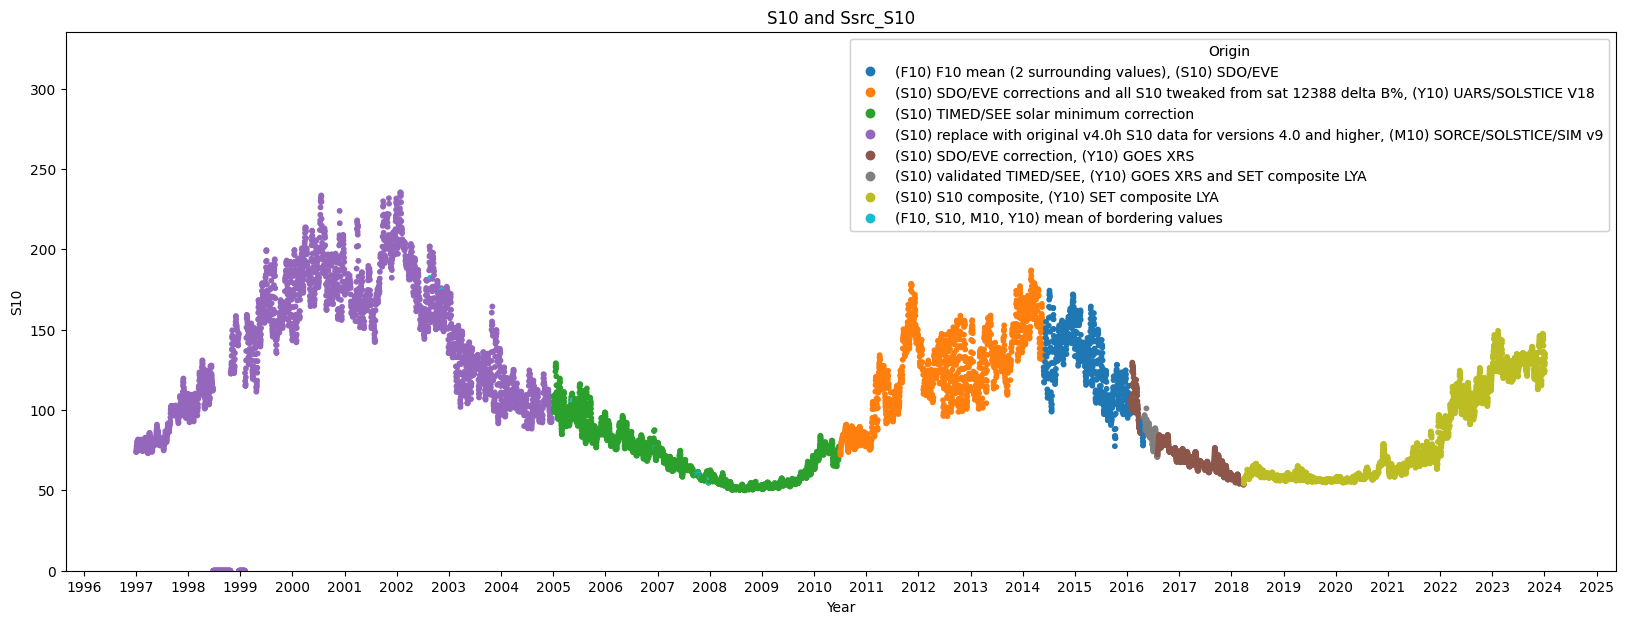

In [10]:
# hide

# Plot the variable S10. The color of the line will be determined by the value of Ssrc_S10
fig, ax = plt.subplots(figsize=(20, 7))
scatter = ax.scatter(df_raw.Datetime, df_raw.S10, c=df_raw.Ssrc_S10.cat.codes, cmap='tab10', s=10)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Year')
ax.set_ylabel('S10')
ax.set_title('S10 and Ssrc_S10')

# Legend configuration
ax.set_ylim(0,max(df_raw.S10)+100)
legend = ax.legend(handles=scatter.legend_elements()[0], labels=S10_legend, loc="best", title="Origin")
ax.add_artist(legend)

## Data Preprocessing

After a quick overview of the data, we are going to preprocess it here.

In [11]:
df_raw.isna().sum()

Year         0
DDD          0
JulianDay    0
F10          0
F81c         0
S10          0
S81c         0
M10          0
M81c         0
Y10          0
Y81c         0
Ssrc         0
Ssrc_F10     0
Ssrc_S10     0
Ssrc_M10     0
Ssrc_Y10     0
Datetime     0
dtype: int64

As we can see in the plot above, it appears that the S10 index has some missing values (represented as 0s) during two periods in 1998 and 1999. To address this missing data, we will first replace these values with NaNs so they can be properly handled by the preprocessing pipeline.


In [12]:
print((df_raw.S10 == 0).sum())

# convert them to NA
df_raw.loc[df_raw.S10 == 0, 'S10'] = np.nan
print((df_raw.S10 == 0).sum())

165
0


To fill the missing data, we have implemented a `PolyImputer` module (you can see more in `nbs/preprocessing.ipynb`), which attempts to fit a polynomial to the available data (excluding the missing values) in order to fill in the gaps. The goal is to preserve the trend of the data points as much as possible. After testing several polynomial fits within a specified range, the module selects the one that minimizes the Wasserstein distance, which measures the difference between two distributions. The selected polynomial values are then imputed into the dataset.

Other preprocessing steps include dropping duplicate values based on time (since there should be no repetition in daily measurements) and reducing the memory size of the dataset.

Initial memory usage: 1.02 MB   
Final memory usage  : 512.20 KB  (-50.8%)
[Pipeline] .......... (step 1 of 3) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 3) Processing drop_duplicates, total=   0.0s
[Pipeline] ...... (step 3 of 3) Processing fill_missing, total=   0.1s


,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Datetime
0,1997,1,2450450.0,72.400002,78.000000,74.000000,79.199997,65.400002,73.800003,61.900002,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,72.099998,77.900002,73.800003,79.099998,66.900002,73.699997,63.400002,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,73.300003,77.599998,75.000000,79.099998,70.099998,73.599998,64.900002,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,73.800003,77.300003,76.300003,79.000000,71.599998,73.400002,65.500000,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,74.400002,76.900002,77.599998,78.900002,72.400002,73.300003,66.699997,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9862,2024,2,2460312.0,137.399994,157.899994,124.500000,133.899994,151.199997,173.699997,162.100006,175.000000,1E11,1,E,1,1,2024-01-02 12:00:00
9863,2024,3,2460313.0,135.500000,158.000000,128.100006,133.899994,153.899994,173.699997,165.800003,175.000000,1E11,1,E,1,1,2024-01-03 12:00:00
9864,2024,4,2460314.0,121.599998,158.100006,129.500000,133.899994,159.399994,173.600006,169.899994,175.100006,1E11,1,E,1,1,2024-01-04 12:00:00
9865,2024,5,2460315.0,147.600006,158.199997,132.600006,133.899994,163.899994,173.500000,173.100006,175.199997,1E11,1,E,1,1,2024-01-05 12:00:00


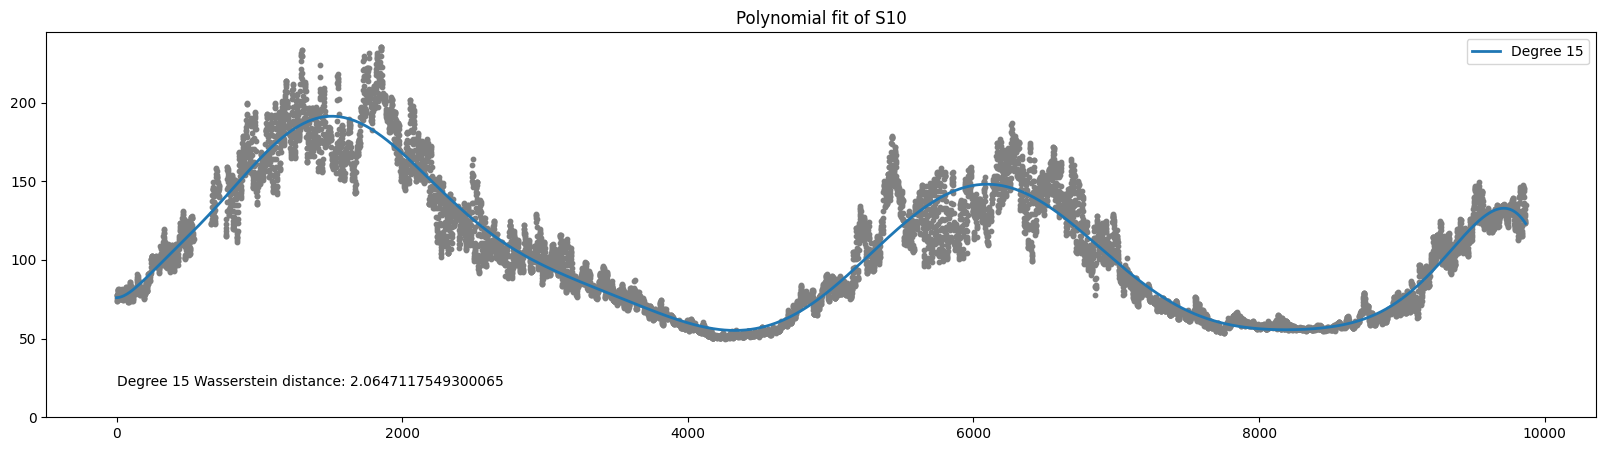

In [13]:
from swdf.preprocessing import PolyImputer
freq = '1D'
data_columns_fcst = config.data_columns
data_columns_time = ['Year', 'DDD']
data_columns = data_columns_fcst + data_columns_time if config.add_time_channels else data_columns_fcst

# sklearn's preprocessing pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrik dataframe memory usage and set the right dtypes
    ('drop_duplicates', TSDropDuplicates(datetime_col='Datetime')), # drop duplicates
    ('fill_missing', PolyImputer(data_columns=data_columns, degrees=np.arange(2,16),plot=True)), # fill missing data (1st ffill. 2nd value=0)
], verbose=True)

df = preproc_pipe.fit_transform(df_raw)
df

Finally we create another pipeline for data standarization that we will later add to the learner pipelines.

In [14]:
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=data_columns)),
], verbose=True)

df_scaled = exp_pipe.fit_transform(df.copy())

save_object(exp_pipe, 'tmp/pipes/exp_pipe.pkl')
df_scaled.head()

[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s
tmp/pipes directory already exists.
Pipeline saved as tmp/pipes/exp_pipe.pkl


,Year,DDD,JulianDay,F10,F81c,S10,S81c,M10,M81c,Y10,Y81c,Ssrc,Ssrc_F10,Ssrc_S10,Ssrc_M10,Ssrc_Y10,Datetime
0,1997,1,2450450.0,-0.897030,78.000000,-0.753263,79.199997,-1.104217,73.800003,-1.288720,70.699997,1B11,1,B,1,1,1997-01-01 12:00:00
1,1997,2,2450451.0,-0.904278,77.900002,-0.758005,79.099998,-1.066566,73.699997,-1.248928,70.400002,1B11,1,B,1,1,1997-01-02 12:00:00
2,1997,3,2450452.0,-0.875287,77.599998,-0.729553,79.099998,-0.986245,73.599998,-1.209136,70.199997,1B11,1,B,1,1,1997-01-03 12:00:00
3,1997,4,2450453.0,-0.863208,77.300003,-0.698729,79.000000,-0.948595,73.400002,-1.193219,69.800003,1B11,1,B,1,1,1997-01-04 12:00:00
4,1997,5,2450454.0,-0.848712,76.900002,-0.667905,78.900002,-0.928514,73.300003,-1.161385,69.599998,1B11,1,B,1,1,1997-01-05 12:00:00


In [15]:
save_object(df, config.df_save_path)
save_object(preproc_pipe, config.preproc_pipe_save_path)
save_object(df_scaled, config.exp_pipe_save_path)

preprocessed_data/dataframes directory already exists.
DataFrame saved as preprocessed_data/dataframes/solfsmy.pkl
preprocessed_data/pipelines directory already exists.
Pipeline saved as preprocessed_data/pipelines/preproc_solfsmy.pkl
preprocessed_data/pipelines directory already exists.
DataFrame saved as preprocessed_data/pipelines/exp_solfsmy.pkl
